In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from cipher.caesar import *
from cipher.affine import *
from cipher.keyword_cipher import *
from cipher.vigenere import *
from cipher.playfair import *
from cipher.column_transposition import *
from support.text_prettify import *
from support.plot_frequency_histogram import *

In [3]:
# import logger as myl
# import logging
# myl.logger.setLevel(logging.DEBUG)
# mylg = logging.getLogger('cipherbreak')
import logging
from logger import logger

import re
from datetime import datetime
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import kendalltau

In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
def commonest_alphabet(text):
    counts = collections.Counter(sanitise(text))
    letters = cat(p[0] for p in counts.most_common())
    return cat(deduplicate(letters + string.ascii_lowercase))

In [6]:
def random_ciphertext(message_length):
    sample_start = random.randint(0, corpus_length - message_length)
    sample = corpus[sample_start:(sample_start + message_length)]
    key = list(string.ascii_lowercase)
    random.shuffle(key)
    key = cat(key)
    ciphertext = keyword_encipher(sample, key)
    return key, ciphertext

In [7]:
def log_parse(text, verbose=False):
    parts = text.split(' - ')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S,%f")
    blurb = parts[-1]
    worker = int(re.search('worker (\d+)', blurb).group(1))
    iteration = int(re.search('iteration (\d+)', blurb).group(1))
    fitness = float(re.search('fitness (-?\d+\.\d+)', blurb).group(1))
    if verbose:
        ca = re.search('current alphabet (\w+)', blurb).group(1)
        pa = re.search('plain alphabet (\w+)', blurb).group(1)
        mapped_ca = cat(p[1] for p in sorted(zip(pa, ca)))
        return {'time': dt, 'worker': worker, 'iteration': iteration, 'fitness': fitness, 
                'cipher_alphabet': ca, 'plain_alphabet': pa, 'mapped_cipher_alphabet': mapped_ca}
    else:
        return {'time': dt, 'worker': worker, 'iteration': iteration, 'fitness': fitness}

In [8]:
# ps = [log_parse(line, verbose=True) for line in open('cipher.log').readlines()[:10]]
# df = pd.DataFrame(ps)
# df = df.set_index(['worker', 'iteration']).sort_index()
# df[['fitness', 'plain_alphabet', 'cipher_alphabet']].to_csv('test.csv', header=True)


In [9]:
def dump_result(starttime, filename, verbose=False, target_cipher_alphabet=''):
    parsed = [log_parse(line, verbose=verbose) for line in open('cipher.log')]
    trace = pd.DataFrame([p for p in parsed if p['time'] > starttime])
    trace = trace.set_index(['worker', 'iteration']).sort_index()
    trace['target_cipher_alphabet'] = target_cipher_alphabet
    workers = list(sorted(set(trace.index.get_level_values(0))))
    if verbose:
        trace[['fitness', 'plain_alphabet', 'cipher_alphabet', 'mapped_cipher_alphabet', 'target_cipher_alphabet']].to_csv(filename, header=True)
    else:
        trace.fitness.to_csv(filename, header=True)
    return workers, trace

In [10]:
plain_alpha = cat(p[0] for p in english_counts.most_common())
plain_alpha

'etoainhsrdlumwycfgpbvkxjqz'

In [11]:
def unscramble_alphabet(cipher_alphabet, plain_alphabet):
    mapping = {p: c for p, c in zip(plain_alphabet, cipher_alphabet)}
    unscrambled = cat(mapping[p] for p in sorted(mapping))
    return unscrambled

In [12]:
# pt = sanitise(open('../2017/8b.plaintext').read())
corpus = sanitise(open('../support/sherlock-holmes.txt').read())
corpus_length = len(corpus)
pt = corpus
pt[:20]

'theadventuresofsherl'

# Development

In [12]:
Pletters(pt)

-542391.5369482826

In [13]:
Ptrigrams(pt)

-1471429.4753165497

In [14]:
commonest_alphabet(pt)

'etaoihnsrdlumwcyfgpbvkxjqz'

In [15]:
k, c = random_ciphertext(30)
k, c, keyword_decipher(c, k)

('sbyopakxntlewgimvfcduqrzhj',
 'seirqinyprxncmpfporselmscdwpsg',
 'alowvoicewhisperedwalkpastmean')

In [16]:
pt = sanitise(open('../2017/8b.plaintext').read())
pt[:20]

'yearningforrespiteth'

In [40]:
ct_key = list(string.ascii_lowercase)
random.shuffle(ct_key)
ct_key = cat(ct_key)
# ct = keyword_encipher(pt, 'arcanaimperii')
ct = keyword_encipher(pt, ct_key)
ct_alpha = commonest_alphabet(ct)
ct[:100]

'qviaysynjpaaverswvwxvapciyeetjjvavzieziqewtayvzsywpfvvmeiyzfvvmesywpcpywxefswxgihnigteiyzwxvgihvzpys'

In [50]:
start_time = datetime.now()
sa_cipher_alphabet, score = simulated_annealing_break(ct, plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha)
sa_cipher_alphabet, score

('vwpisyxeazhtcfqgjnrokmldbu', -14681.308607565503)

In [51]:
ct_key

'iogzvjnxsdmhcyprbaewtkflqu'

In [52]:
cat(p[1] for p in sorted(zip(plain_alpha, sa_cipher_alphabet)))

'iogzvjnxsdmhcyprbaewtkflqu'

In [53]:
keyword_cipher_alphabet_of('arcanaimperii')

'arcnimpebdfghjkloqstuvwxyz'

In [54]:
!ls *log

cipher.log  old.cipher.log


In [55]:
recs = open('cipher.log').read().splitlines()
recs[:5]

['2019-10-28 09:59:14,978 - cipherbreak - DEBUG - Simulated annealing worker 2: iteration 0, temperature 200, current alphabet rjgzieptunyxodfsmbacqhkwvl, plain alphabet etoainhsrdlumwycfgpbvkxjqz, current_fitness -17464.568516864027, best_plaintext getsninycassehpioeoresamtnhhuccesedthdtghousnedino',
 '2019-10-28 09:59:14,978 - cipherbreak - DEBUG - Simulated annealing worker 8: iteration 0, temperature 200, current alphabet rjgzieptunyxocfsmbadqhkwvl, plain alphabet etoainhsrdlumwycfgpbvkxjqz, current_fitness -17394.10216261065, best_plaintext geosninycassehpitetresamonhhuccesedohdoghtusnedint',
 '2019-10-28 09:59:14,980 - cipherbreak - DEBUG - Simulated annealing worker 0: iteration 0, temperature 200, current alphabet rjgzieptunyxodcsmbafqhkwvl, plain alphabet etoainhsrdlumwycfgpbvkxjqz, current_fitness -17476.383874573305, best_plaintext geosninbcassehpitetresamonhhuccesedohdoghtusnedint',
 '2019-10-28 09:59:14,980 - cipherbreak - DEBUG - Simulated annealing worker 1: iteration 0,

In [66]:
log_parse(recs[0])

{'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 978000),
 'worker': 2,
 'iteration': 0,
 'fitness': -17464.568516864027}

In [57]:
parsed = [log_parse(line) for line in open('cipher.log')]
parsed[:5]

[{'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 978000),
  'worker': 2,
  'iteration': 0,
  'fitness': -17464.568516864027},
 {'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 978000),
  'worker': 8,
  'iteration': 0,
  'fitness': -17394.10216261065},
 {'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 980000),
  'worker': 0,
  'iteration': 0,
  'fitness': -17476.383874573305},
 {'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 980000),
  'worker': 1,
  'iteration': 0,
  'fitness': -17464.568516864027},
 {'time': datetime.datetime(2019, 10, 28, 9, 59, 14, 980000),
  'worker': 4,
  'iteration': 0,
  'fitness': -17464.568516864027}]

In [58]:
# threshold = datetime(2018, 12, 6, 1)
trace = pd.DataFrame([p for p in parsed if p['time'] > start_time])
trace = trace.set_index(['worker', 'iteration']).sort_index()
trace

fitness                    time
worker iteration                                      
0      0         -17464.568517 2019-10-28 10:14:21.136
       500       -18531.679762 2019-10-28 10:14:22.493
       1000      -20903.487109 2019-10-28 10:14:23.787
       1500      -19941.571807 2019-10-28 10:14:25.084
       2000      -18871.699801 2019-10-28 10:14:26.133
       2500      -18847.246876 2019-10-28 10:14:27.408
       3000      -19111.386196 2019-10-28 10:14:28.707
       3500      -19693.452817 2019-10-28 10:14:29.835
       4000      -18959.289175 2019-10-28 10:14:31.228
       4500      -19040.556583 2019-10-28 10:14:32.569
       5000      -18169.812374 2019-10-28 10:14:33.891
       5500      -16657.860123 2019-10-28 10:14:35.200
       6000      -16220.268468 2019-10-28 10:14:36.485
       6500      -16472.952274 2019-10-28 10:14:37.784
       7000      -17046.418912 2019-10-28 10:14:39.054
       7500      -17320.865489 2019-10-28 10:14:40.343
       8000      -16438.413488 2019-10-28 10:14:41.622
       8500      -16116.768242 2019-10-28 10:14:42.893
       9000      -16085.659977 2019-10-28 10:14:44.167
       9500      -15679.574171 2019-10-28 10:14:45.405
       10000     -16473.325447 2019-10-28 10:14:46.650
       10500     -16421.027387 2019-10-28 10:14:48.070
       11000     -16167.752107 2019-10-28 10:14:49.371
       11500     -15213.074262 2019-10-28 10:14:50.686
       12000     -15634.979337 2019-10-28 10:14:51.967
       12500     -15296.397297 2019-10-28 10:14:52.824
       13000     -15025.983510 2019-10-28 10:14:53.881
       13500     -15175.912750 2019-10-28 10:14:54.871
       14000     -15235.513700 2019-10-28 10:14:56.119
       14500     -14923.520462 2019-10-28 10:14:57.339
...                        ...                     ...
9      5000      -19218.644968 2019-10-28 10:14:34.337
       5500      -18770.828622 2019-10-28 10:14:35.625
       6000      -18390.233128 2019-10-28 10:14:36.920
       6500      -17361.547211 2019-10-28 10:14:38.208
       7000      -16846.113490 2019-10-28 10:14:39.501
       7500      -15002.318165 2019-10-28 10:14:40.762
       8000      -16992.780932 2019-10-28 10:14:41.757
       8500      -17115.242295 2019-10-28 10:14:43.037
       9000      -17297.012437 2019-10-28 10:14:44.327
       9500      -16511.948405 2019-10-28 10:14:45.552
       10000     -16175.059178 2019-10-28 10:14:46.828
       10500     -15482.711195 2019-10-28 10:14:48.096
       11000     -15190.359782 2019-10-28 10:14:49.376
       11500     -15776.667896 2019-10-28 10:14:50.523
       12000     -15112.798387 2019-10-28 10:14:51.327
       12500     -15539.267169 2019-10-28 10:14:52.194
       13000     -15209.937930 2019-10-28 10:14:52.907
       13500     -14917.833732 2019-10-28 10:14:53.804
       14000     -14822.068093 2019-10-28 10:14:54.706
       14500     -14996.772583 2019-10-28 10:14:55.742
       15000     -14818.384023 2019-10-28 10:14:57.001
       15500     -14698.864982 2019-10-28 10:14:58.250
       16000     -14689.841559 2019-10-28 10:14:59.546
       16500     -14698.864982 2019-10-28 10:15:00.651
       17000     -14681.308608 2019-10-28 10:15:01.702
       17500     -14681.308608 2019-10-28 10:15:02.920
       18000     -14681.308608 2019-10-28 10:15:04.255
       18500     -14681.308608 2019-10-28 10:15:05.523
       19000     -14681.308608 2019-10-28 10:15:06.791
       19500     -14681.308608 2019-10-28 10:15:08.055

[400 rows x 2 columns]

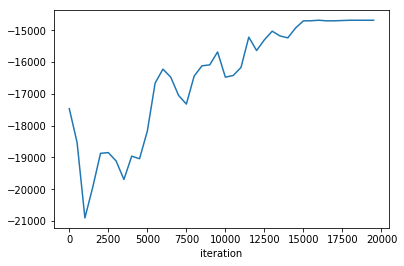

In [59]:
trace.loc[0].fitness.plot()

In [60]:
workers = list(sorted(set(trace.index.get_level_values(0))))
workers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

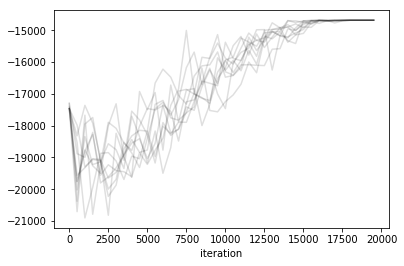

In [61]:
fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')
#     trace2.loc[w].fitness.plot(ax=ax, color='#00000020')

In [67]:
dump_result(start_time, 'test.csv', verbose=True, target_cipher_alphabet=ct_key)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cipher_alphabet       fitness  \
 worker iteration                                             
 0      0          vwipsyeaxzhtcgnjfqrkomlbdu -17464.568517   
        500        veishcowyqapntgjkzxlfrbmud -18531.679762   
        1000       eipyvanfzdotkswqcxrugjhmbl -20903.487109   
        1500       vogicqjwyahpsfzxenutkmldbr -19941.571807   
        2000       vypiczksxwhenrdatfjgqlobmu -18871.699801   
        2500       vwsiaexrybzpfuhqjgtmlnckod -18847.246876   
        3000       vwpsienacxzfbjudtqyholgmrk -19111.386196   
        3500       xyvsiecalghpzkutbofwnjdqrm -19693.452817   
        4000       iptvweayszhfnqjcuxrgbkomdl -18959.289175   
        4500       tyivpenshxcqzrfagwkjdbuolm -19040.556583   
        5000       pwivsjmyafxterockhznqlbgdu -18169.812374   
        5500       vwpisyxaogetcuqznrjhfdlkbm -16657.860123   
        6000       vwpisyxzajhtcfgeunobqmrdlk -16220.268468   
        6500       vwp

# Experiments

In [13]:
ct_key, ct = random_ciphertext(2000)
ct_alpha = commonest_alphabet(ct)
collections.Counter(sanitise(ct)).most_common()[-5:]

[('f', 24), ('w', 12), ('h', 3), ('z', 1), ('b', 1)]

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

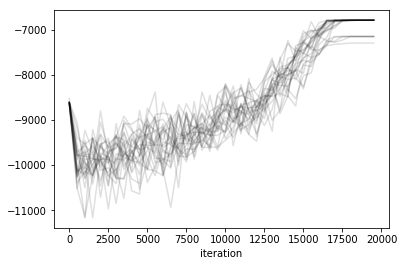

In [71]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
# workers, trace = dump_result(start_time, 'sa-given-trigram-gaussian.csv', verbose=True)
workers, trace = dump_result(start_time, 'test.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-2516.00992398943


('qkicfaygbnweojuxhptlsvrdmz',
 'bkrefavguhwcstlxnpjqiyodmz',
 0.4338461538461538)

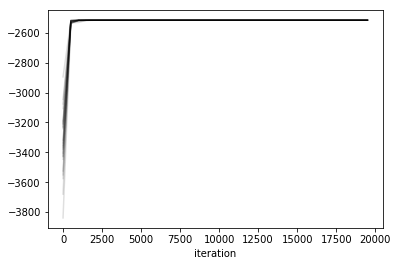

In [72]:
start_time = datetime.now()
found_cipher_alphabet, score = monoalphabetic_break_hillclimbing_mp(
    ct, 
    swap_index_finder=uniform_swap_index, 
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'hillclimbing-random-unigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

ct_key, found_cipher_alphabet, kendalltau([ord(c) for c in found_cipher_alphabet], [ord(c) for c in ct_key])[0]

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz', 'qkicfaygbnweojuxhptlsvrdmz', 1.0)

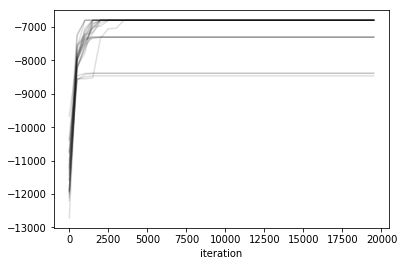

In [73]:
start_time = datetime.now()
found_cipher_alphabet, score = monoalphabetic_break_hillclimbing_mp(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index, 
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'hillclimbing-random-trigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

ct_key, found_cipher_alphabet, kendalltau([ord(c) for c in found_cipher_alphabet], [ord(c) for c in ct_key])[0]    

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

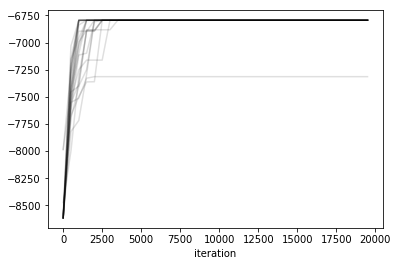

In [74]:
start_time = datetime.now()
found_cipher_alphabet, score = monoalphabetic_break_hillclimbing_mp(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'hillclimbing-given-trigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')


( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

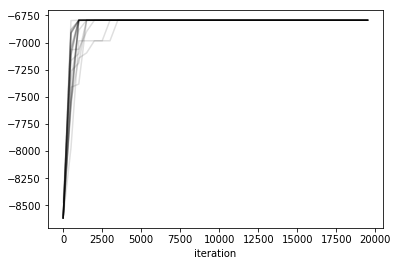

In [75]:
start_time = datetime.now()
found_cipher_alphabet, score = monoalphabetic_break_hillclimbing_mp(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'hillclimbing-given-trigram-gaussian.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)


-2516.00992398943


('qkicfaygbnweojuxhptlsvrdmz',
 'bkrefavguhwcstlxnpjqiyodmz',
 0.4338461538461538)

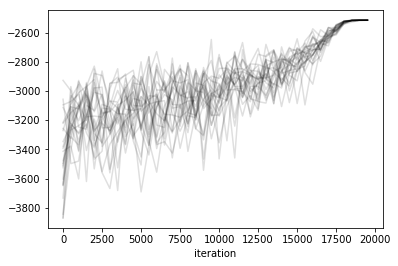

In [76]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    swap_index_finder=uniform_swap_index,
    fitness=Pletters,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-random-unigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 kendalltau([ord(c) for c in found_cipher_alphabet], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz', 'qkicfaygbnweojuxhptlsvrdmz', 1.0)

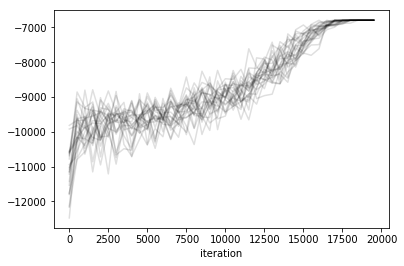

In [77]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index, 
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-random-trigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 kendalltau([ord(c) for c in found_cipher_alphabet], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz', 'qkicfaygbnweojuxhptlsvrdmz', 1.0)

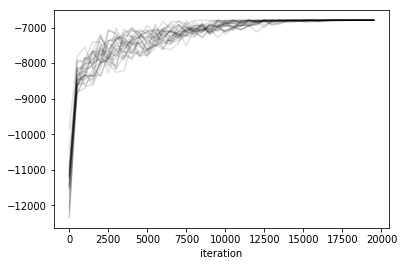

In [78]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index, 
    initial_temperature=50,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-random-trigram-uniform-50.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 kendalltau([ord(c) for c in found_cipher_alphabet], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

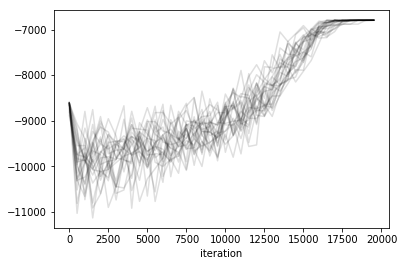

In [79]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-given-trigram-uniform.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

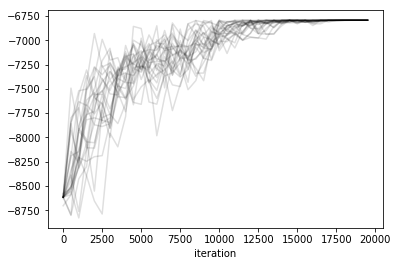

In [80]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=uniform_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    initial_temperature=50,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-given-trigram-uniform-50.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

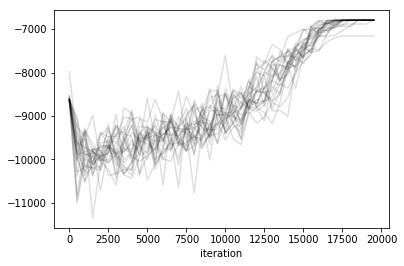

In [81]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-given-trigram-gaussian.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6794.348261349827


('qkicfaygbnweojuxhptlsvrdmz',
 'fluqbjgtpcesormiayxkvwdnhz',
 'qkicfaygbnweojuxhptlsvrdmz',
 1.0)

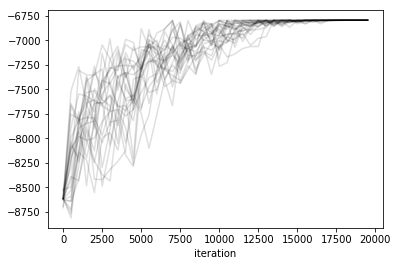

In [82]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
    plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    initial_temperature=50,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-given-trigram-gaussian-50.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6762.926106391538


('giaonvysthwmxpcqkdelrfjbuz',
 'giaonvysthwmxpcqkdelrfjbuz',
 'olqhgkdynbfwxvaeutsimrpjcz',
 0.009230769230769232)

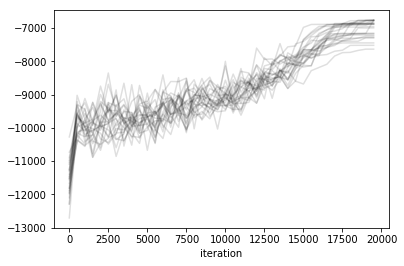

In [19]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
#     plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-random-trigram-gaussian.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

-6762.926106391538


('giaonvysthwmxpcqkdelrfjbuz',
 'giaonvysthwmxpcqkdelrfjbuz',
 'olqhgkdynbfwxvaeutsimrpjcz',
 0.009230769230769232)

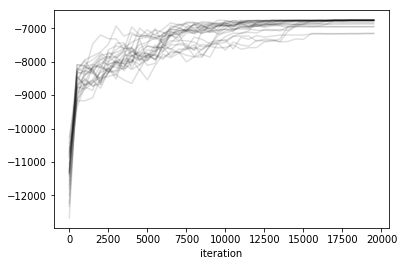

In [20]:
start_time = datetime.now()
found_cipher_alphabet, score = simulated_annealing_break(
    ct, 
    fitness=Ptrigrams,
    swap_index_finder=gaussian_swap_index,
#     plain_alphabet=plain_alpha, cipher_alphabet=ct_alpha,
    initial_temperature=50,
    workers=24)
print(score)
workers, trace = dump_result(start_time, 'sa-random-trigram-gaussian-50.csv', verbose=True, target_cipher_alphabet=ct_key)

fig, ax = plt.subplots()
for w in workers:
    trace.loc[w].fitness.plot(ax=ax, color='#00000020')

( ct_key, found_cipher_alphabet, 
 unscramble_alphabet(found_cipher_alphabet, plain_alpha), 
 kendalltau([ord(c) for c in unscramble_alphabet(found_cipher_alphabet, plain_alpha)], [ord(c) for c in ct_key])[0]
)

In [16]:
import glob

In [17]:
for f in glob.glob("*unigram*.csv"):
    df = pd.read_csv(f)
    print(df.fitness.max(), df.fitness.min(), f)

-2516.00992398943 -3869.307250218112 sa-random-unigram-uniform.csv
-2516.00992398943 -3839.3134735383337 hillclimbing-random-unigram-uniform.csv


In [18]:
for f in glob.glob("*trigram*.csv"):
    df = pd.read_csv(f)
    print(df.fitness.max(), df.fitness.min(), f)

-6794.348261349826 -12720.143220102082 hillclimbing-random-trigram-uniform.csv
-6762.926106391538 -9052.2968971747 sa-given-trigram-uniform-50.csv
-6794.348261349826 -12353.066243453513 sa-random-trigram-uniform-50.csv
-6794.348261349826 -8615.89272592576 hillclimbing-given-trigram-uniform.csv
-6794.348261349826 -11354.213044609856 sa-given-trigram-gaussian.csv
-6794.348261349826 -8615.89272592576 hillclimbing-given-trigram-gaussian.csv
-6794.348261349826 -12473.766416410037 sa-random-trigram-uniform.csv
-6794.348261349826 -8812.095650467198 sa-given-trigram-gaussian-50.csv
-6762.926106391538 -11431.418729152087 sa-given-trigram-uniform.csv
